In [1]:
#hack till I make it a real package..
import os
import sys
sys.path.append("../../")
#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '3,4'
import jax 
import jax.numpy as jnp

jax.config.update('jax_disable_jit', False)
jax.config.update('jax_debug_nans', False)

import diffhydro as dh
from diffhydro.utils.io import athinput,athdf
%pylab inline


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
#load athena ICs
import h5py
import jax.numpy as jnp
from diffhydro.utils.io import athinput,athdf

athena_outputs_loc = "../../sims/"

ic_filename = "multiblast.out3.00021.athdf"


ICs = athdf(athena_outputs_loc+ic_filename)



FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../../sims/multiblast.out3.00021.athdf', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [3]:

sol = jnp.zeros((5,100,100,100))
sol = sol.at[0].set(ICs["dens"])
sol = sol.at[-1].set(ICs["Etot"])

2025-10-27 23:03:12.446264: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.6 which is older than the PTX compiler version 12.9.86. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
#this conduction is broken... :'(

eq = dh.equationmanager.EquationManager()
eq.thermal_conductivity_model = "ELBADRY"

#eq.box_size = (128.0, 256.0,1.0)
ss = dh.signal_speed_Rusanov
solver = dh.HLLC(equation_manager=eq,signal_speed=ss)
cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"))

conductive_flux = dh.ConductiveFlux(eq, None, None,zeta= 5.111496271545331e-12)

hydrosim = dh.hydro(n_super_step=int(1
                                    ),fluxes=[cf,conductive_flux],use_mol=True)#splitting_schemes=[[2,1,1,2],[1,2,2,1],])

using CTU? False


In [5]:
prim = eq.get_primitives_from_conservatives(sol)
T = eq.get_temperature(prim[-1],prim[0])

In [7]:
T.max()

Array(4.6090145e+06, dtype=float32)

In [5]:

params = {}
q = hydrosim.evolve(sol,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]
using CTU? False


In [6]:
conductive_flux.timestep(sol)

Array(3.0324886e-16, dtype=float32)

In [7]:

prim = eq.get_primitives_from_conservatives(q[0])
rho  = prim[0]
p    = prim[-1]
T    = eq.get_temperature(p, rho)

In [8]:
cp_m = eq.get_specific_heat_capacity(T)  # per-unit-mass c_p

# Unsaturated conductivity from the manager (face eval not required for dt)
kappa_unsat = eq.get_thermal_conductivity(T, prim)


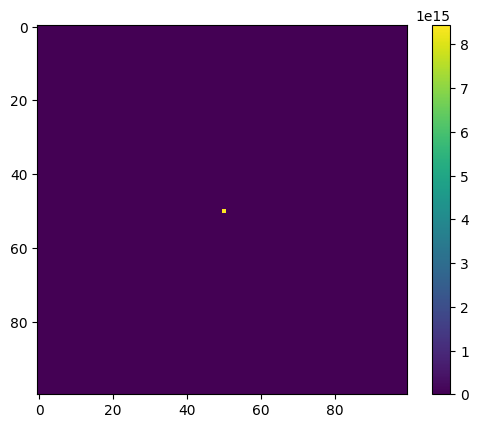

In [9]:
imshow(kappa_unsat[50])
colorbar()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


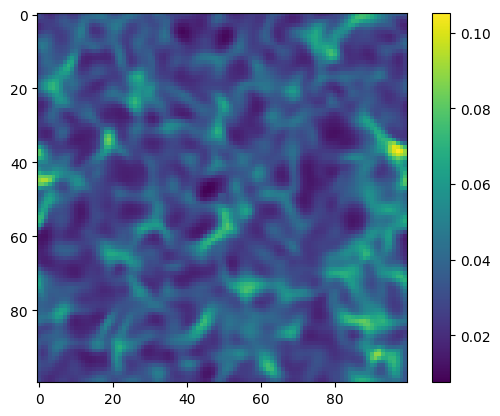

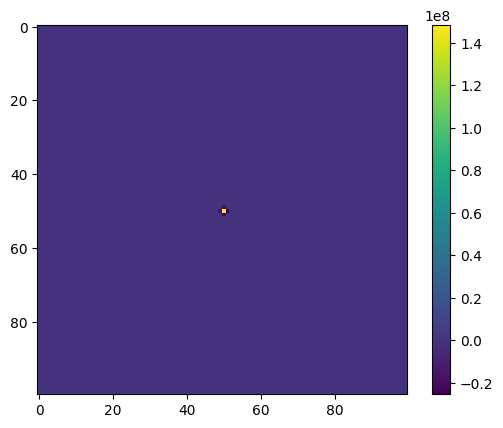

In [10]:
%pylab inline
imshow(q[0][0][50])
colorbar()
show()
imshow(q[0][-1][50])
colorbar()

In [12]:
cooling_table = np.genfromtxt("../../data/m-00.cie")
logT, logLambda_m20 = cooling_table[:,0],cooling_table[:,1]

from functools import partial
import jax
import jax.numpy as jnp
from jax import lax

#another attempt...
class AthenaCoolingForce:
    """
    Radiative cooling (and optional heating) as a source/forcing term, matching the
    Athena multiblast setup:
      - T < 1e4 K: Koyama & Inutsuka (2002) cooling (+ optional heating)
      - 1e4 K <= T <= 10^8.5 K: Sutherland & Dopita (1993) via tabulated log10 Λ(T)-20
      - T  > 10^8.5 K: linear extrapolation using last two table points
    Subcycling: 10 micro-steps per hydro step with early exit if t_cool large.
    Timestep limiter: min(ctime * |E/Edot|, dtmax), computed on current state.
    Units/coeffs match the uploaded Athena file; change if your units differ.
    """

    def __init__(
        self,
        equation_manager,
        pressure_fn,
        logT_table,                # shape [N], log10 T grid (monotonic, e.g. 4.0 .. 8.5)
        logLambda_m20_table,       # shape [N], values of (log10 Λ - 20) at logT_table
        *,
        # --- coefficients taken from Athena multiblast config (simulation units):
        ALPHA = 813.142554365,         # low-T cooling prefactor
        BETA  = 406571277.182611837,   # high-T cooling prefactor
        GAMMA = 406.571277183,         # low-T heating prefactor (toggle via include_heating)
        MHKB  = 115.98518596699539,    # m_H / k_B in code units
        include_heating = True,
        # timestep control used there:
        ctime = 1.0,       # coefficient (Athena stores this in ruser)
        dtmax = 1.0,       # ceiling (Athena stores this in ruser)
        temp_floor = 1.0e4,    # optional temperature floor (Athena uses ruser)
        subcycles = 30,    # 10 micro-steps like their NOSUBCYCLE guard
        early_exit = True, # early exit if t_cool > dt/ctime (as in their code)
        eps = 1e-30
    ):
        self.eq = equation_manager
        self.pressure_fn = pressure_fn
        self.logT = jnp.asarray(logT_table)
        self.logL = jnp.asarray(logLambda_m20_table)
        self.ALPHA = ALPHA
        self.BETA  = BETA
        self.GAMMA = GAMMA
        self.MHKB = MHKB
        self.include_heating = include_heating
        self.ctime = ctime
        self.dtmax = dtmax
        self.temp_floor = temp_floor
        self.subcycles = int(subcycles)
        self.early_exit = early_exit
        self.eps = eps

        # indices from equation manager (mass, momentum, energy)
        self.i_rho = self.eq.mass_ids
        # momentum indices not needed; we only touch thermal energy (via total energy slot)
        self.i_E   = self.eq.energy_ids

        # constants and thresholds used in Athena’s routine
        self._Tmin = 1.0e4
        self._Tmax = 10.0**8.5
        # convenience: factor 1.4/1.1 = 14/11 ≈ 1.272727... used in that file for T
        self._Tcoef = 14.0 / 11.0

    # -----------------------
    # Internal helpers
    # -----------------------
    def _finite_pos(self, x, floor):
        # use only finite & >0 entries; otherwise substitute a conservative floor
        return jnp.where(jnp.isfinite(x) & (x > 0.0), x, floor)
    
    def _T_phys(self, P, rho):
        # Athena’s temperature (Kelvin-like): (14/11)*(mH/kB)*P/rho
        rho_s = self._finite_pos(rho, self.eps)
        P_s   = self._finite_pos(P,   self.eps)
        return (14.0/11.0) * self.MHKB * P_s / rho_s
        
    def _temp_from_rhoP(self, rho, P):
        # T = (14/11) * (m_H / k_B) * P / rho   [matches the Athena file]
        return self._Tcoef * self.MHKB * P / jnp.maximum(rho, self.eps)

    def _Et_from_P(self, P, gamma):
        # Thermal energy density: Et = P / (gamma - 1); for gamma=5/3, Et=1.5 P
        return P / (gamma - 1.0)
        
    def _interp_logLambda_m20(self, logT):
        # assumes table grid is logT = 4.0 + 0.05*i  (i=0..N)
        p = jnp.floor((logT - 4.0) / 0.05).astype(int)
        p = jnp.clip(p, 0, self.logL.size - 2)
        q = (logT - 4.0) / 0.05
        y = self.logL[p]   * (q - 1.0 * p) + \
            self.logL[p+1] * (1.0 * p - q + 1.0)
        # above 10^8.5: extrapolate with the last two points (as Athena)
        over = logT > 8.5
        slope = 20.0 * (self.logL[-1] - self.logL[-2])
        y_over = slope * (logT - 8.5) + self.logL[-1]
        return jnp.where(over, y_over, y)

    def _cooling_heating_rate(self, rho, T):
        """
        Compute dotE (energy change rate density) following the Athena routine:
          dotE = rho^2 * [ -Λ(T)  +  (heating if enabled & T<1e4) ]
        Returns dotE in simulation units matching ALPHA/BETA/GAMMA usage.
        """
        T = jnp.where(jnp.isfinite(T), T, self._Tmin)
        T = jnp.clip(T, 1.0, self._Tmax)  # 

        logT = jnp.log10(jnp.maximum(T, self.eps))

        # Low-T branch (T < 1e4 K): Koyama & Inutsuka 2002 + optional heating
        low = T < self._Tmin
        # KI02 cooling piece:
        low_cool = self.ALPHA * rho * rho * (
            1.0e7 * jnp.exp(-118400.0 / (T + 1000.0)) + 0.014 * jnp.sqrt(jnp.maximum(T, 0.0)) * jnp.exp(-92.0 / jnp.maximum(T, self.eps))
        )
        # Kim & Ostriker 2015 heating:
        low_heat = jnp.where(self.include_heating, self.GAMMA * rho * rho, 0.0)
        dotE_low = -low_cool + low_heat

        # High-T table branch (1e4 <= T): Sutherland & Dopita 1993 (tabulated)
        y = self._interp_logLambda_m20(logT)  # y = log10 Λ - 20
       # y    = jnp.clip(y, -40.0, -10.0)      # i.e. Λ in [1e-40, 1e-10]×1e20

        Lambda = 10.0**y                       # this is dimensionless “Λ * 1e20” factor
        dotE_high = -self.BETA * rho * rho * Lambda

        return jnp.where(low, dotE_low, dotE_high)

    # -----------------------
    # Public API: dt limiter
    # -----------------------
    def timestep_old(self, U):
        W = self.eq.get_primitives_from_conservatives(U)
        rho = jnp.maximum(W[self.i_rho], self.eps)
        P   = jnp.maximum(W[self.i_E],   self.eps)
        gamma = getattr(self.eq, "gamma", 5.0/3.0)
        Et  = P / (gamma - 1.0)
    
        # Athena-style "physical" temperature used for rates
        T   = (14.0/11.0) * self.MHKB * P / rho
    
        # Use the floor only for the RATE; don't lift Et here
        T_eff  = jnp.maximum(T, self.temp_floor if self.temp_floor is not None else 0.0)
        dotE   = self._cooling_heating_rate(rho, T_eff)
    
        # Effective Et and |dotE| with floors to avoid 0/0 and absurd spikes
        Et_eff   = jnp.maximum(Et, self.eps)
        rate_eff = jnp.maximum(jnp.abs(dotE), 1e-30)
    
        tcool = Et_eff / rate_eff
    
        # Ignore cells already at/near the floor (cooling effectively turned off there)
        near_floor = (T <= (self.temp_floor if self.temp_floor is not None else 0.0) * 1.01)
        tcool = jnp.where(near_floor, jnp.inf, tcool)
    
        # Optional: absolute lower bound so one pathological cell doesn’t halt the sim
        tcool_floor = 1e-12  # code time units; tune to your problem
        tcool = jnp.maximum(tcool, tcool_floor)
    
        dt_cool = self.ctime * jnp.min(tcool)
        return jnp.minimum(dt_cool, self.dtmax)
        
    def timestep(self, U):
        rho = self._finite_pos(U[self.i_rho], self.eps)
        P   = self._finite_pos(self.pressure_fn(U), self.eps)
    
        gamma = getattr(self.eq, "gamma", 5.0/3.0)
        Et    = P / (gamma - 1.0)
    
        T     = self._T_phys(P, rho)
        T_eff = jnp.maximum(T, self.temp_floor if self.temp_floor is not None else 0.0)
    
        # dotE must be finite; guard T inside the rate too
        dotE  = self._cooling_heating_rate(rho, T_eff)
        rate  = jnp.maximum(jnp.abs(dotE), 1e-30)
    
        tcool = jnp.maximum(Et, self.eps) / rate
    
        # ignore cells at/near the floor so they don't collapse dt
        near_floor = (T <= (self.temp_floor if self.temp_floor is not None else 0.0) * 1.01)
        tcool = jnp.where(near_floor, jnp.inf, tcool)
    
        dt_cool = self.ctime * jnp.min(tcool)
        return jnp.minimum(dt_cool, self.dtmax)   
        
    def _thermo_from_U(self, U):
        # Use EquationManager to avoid unit/definition mismatches
        W = self.eq.get_primitives_from_conservatives(U)
        rho = jnp.maximum(W[self.i_rho], self.eps)
        P   = jnp.maximum(W[self.i_E],   self.eps)      # 'energy_ids' indexes pressure in primitives
        T   = self.eq.get_temperature(P, rho)
        gamma = getattr(self.eq, "gamma", 5.0/3.0)
        Et  = P / (gamma - 1.0)                         # thermal energy density
        return rho, P, T, Et, gamma

    # -----------------------
    # Public API: apply forcing
    # -----------------------

    def force(self, i_step, U, params, dt):
        # Conservative-to-thermo with finite guards (no EquationManager changes)
        rho = self._finite_pos(U[self.i_rho], self.eps)
        P   = self._finite_pos(self.pressure_fn(U), self.eps)
        gamma = getattr(self.eq, "gamma", 5.0/3.0)
    
        Et = P / (gamma - 1.0)
        T0 = self._T_phys(P, rho)
    
        # Early-exit heuristic evaluated at start (rate uses floored T)
        T_eff0 = jnp.maximum(T0, self.temp_floor if self.temp_floor is not None else 0.0)
        dotE0  = self._cooling_heating_rate(rho, T_eff0)
        tcool0 = jnp.maximum(Et, self.eps) / jnp.maximum(jnp.abs(dotE0), 1e-30)
        slow   = self.early_exit & (tcool0 > (dt / jnp.maximum(self.ctime, self.eps)))
    
        dt_loc = dt / float(self.subcycles)
        f_max  = 0.3  # lose at most 30% of Et per subcycle
    
        def body(i, carry):
            Tcur, Etcur = carry
    
            # ensure current state is finite/usable before rate eval
            Tcur  = jnp.where(jnp.isfinite(Tcur),  Tcur,  self.temp_floor if self.temp_floor is not None else 0.0)
            Etcur = jnp.where(jnp.isfinite(Etcur), Etcur, self.eps)
            Etcur = jnp.maximum(Etcur, self.eps)
    
            # RATE at floored temperature (no energy injection here)
      #      T_eff = jnp.maximum(Tcur, self.temp_floor if self.temp_floor is not None else 0.0)
            T_eff = jnp.maximum(Tcur, self.temp_floor or 0.0)
            near_floor = T_eff <= (self.temp_floor or 0.0) * 1.01
            dotE = jnp.where(near_floor, 0.0, self._cooling_heating_rate(rho, T_eff))
           # dotE  = self._cooling_heating_rate(rho, T_eff)
            dE    = dotE * dt_loc
    
            # fractional cap prevents overshoot to negative Et
            dE    = jnp.maximum(dE, -f_max * Etcur)
    
            Etnew = jnp.maximum(Etcur + dE, self.eps)
    
            Pnew  = (gamma - 1.0) * Etnew
            Tnew  = self._T_phys(Pnew, rho)
    
            # keep next state finite (without nan_to_num)
            Tnew  = jnp.where(jnp.isfinite(Tnew),  Tnew,  T_eff)  # fall back to rate-T if needed
            Etnew = jnp.where(jnp.isfinite(Etnew), Etnew, self.eps)
    
            return (Tnew, Etnew)
    
        T_sub, Et_sub = lax.fori_loop(0, int(self.subcycles), body, (T0, Et))
        Et_final = jnp.where(slow, jnp.maximum(Et + dotE0 * dt, self.eps), Et_sub)
    
        dE = Et_final - Et

        return U.at[self.i_E].add(dE)

In [14]:
#def pressure_from_manager(eq, U):
#    W = eq.get_primitives_from_conservatives(U)
#    # In your managers, primitives[energy_ids] is pressure; clamp numerically
#    return jnp.maximum(W[eq.energy_ids], eq.eps)

    
cool = dh.cooling.HeatCoolForce(
    equation_manager=eq,
    pressure_fn=lambda U: pressure_from_manager(eq, U),
    logT_table=logT,
    logLambda_m20_table=logLambda_m20,
    include_heating=True,
    early_exit= True,
    ctime= 0.2,
    dtmax= 1E10,
    temp_floor=10.0
)


In [15]:
eq.cfl=0.6

ss = dh.signal_speed_Rusanov

solver = dh.HLLC(equation_manager=eq,signal_speed=ss)
cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"),positivity=False)
#matches 1000 at step 330 #930 #932
hydrosim = dh.hydro(n_super_step=int(660),fluxes=[cf], forces=[cool],use_mol=True,integrator='RK2')

using CTU? False


In [16]:
#sol[0]+np.random.randn(100,100,100)*1E-6

In [17]:

sol = jnp.zeros((5,100,100,100))
sol = sol.at[0].set(ICs["dens"])
sol = sol.at[-1].set(ICs["Etot"])

params = {}
q_cool = hydrosim.evolve(sol,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>]
using CTU? False


In [18]:
cf.timestep(sol),cool.timestep(q_cool[0])

(Array(0.00022095, dtype=float32), Array(7.696103e-05, dtype=float32))

In [19]:
np.argwhere(np.isnan(q_cool[0]))

array([], shape=(0, 4), dtype=int64)

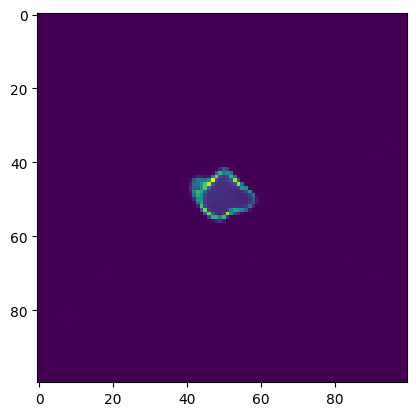

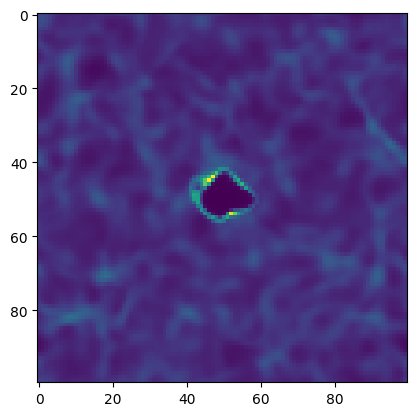

In [20]:
#nailed the sign flip..
imshow(q_cool[0][-1][44])
show()
imshow(q_cool[0][0][44])

In [21]:
output_cool = cool.force(0,q_cool[0],params,7.364885e-05)

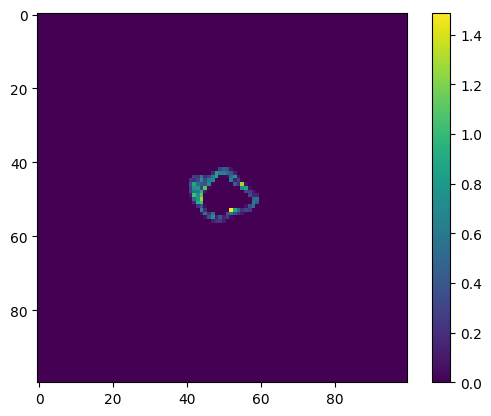

In [22]:
imshow(q_cool[0][-1][44]-output_cool[-1][44])
colorbar()

In [23]:
q_cool[0][-1].min(),q_cool[0][-1].max()

(Array(0.11949448, dtype=float32), Array(738.173, dtype=float32))

In [24]:
q_cool[0][0].min(),q_cool[0][0].max()

(Array(0.0002063, dtype=float32), Array(0.2479017, dtype=float32))

In [25]:
q_cool[0][-1].sum(),q[0][-1].sum(),sol[-1].sum()

(Array(1.7197324e+06, dtype=float32),
 Array(3.015872e+06, dtype=float32),
 Array(3.0158985e+06, dtype=float32))

In [26]:

is_filename = "multiblast.out3.02208.athdf"


ISs = athdf(athena_outputs_loc+is_filename)

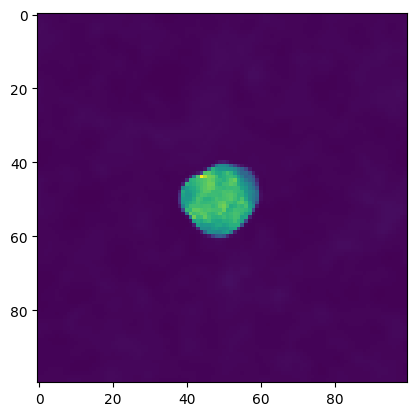

In [27]:
imshow(q_cool[0][-1][:,:,:].sum(axis=1))


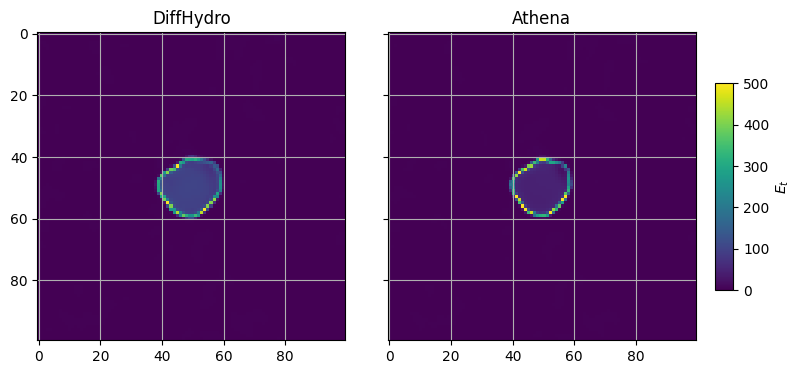

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax = plt.subplots(1,2,sharey=True,figsize=(9,4))
ax[0].imshow(q_cool[0][-1][:,50],vmin=0,vmax=500)
ax[0].grid()
ax[0].set_title("DiffHydro")

pcm1=ax[1].imshow(ISs['Etot'][:,50],vmin=0,vmax=500)
ax[1].grid()
ax[1].set_title("Athena")


divider = make_axes_locatable( ax[1])
cax1 = fig.add_axes([0.90, 0.235, 0.02, 0.518])
plt.colorbar(pcm1, cax=cax1,label="$E_t$")
fig.subplots_adjust(hspace=0.01,wspace=0.01)
plt.savefig("cooling.pdf")
show()

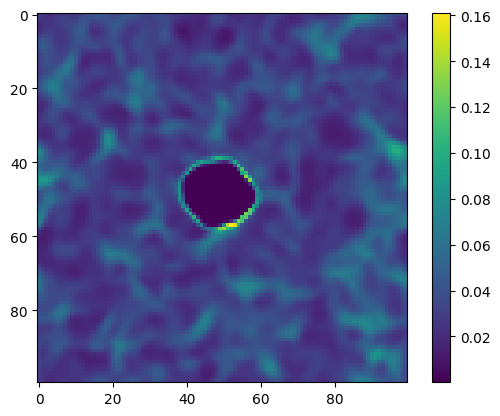

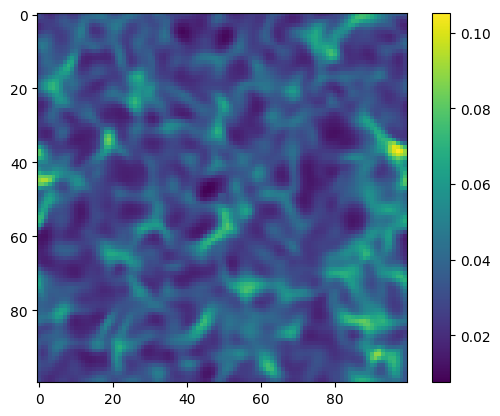

In [271]:
imshow(q_cool[0][0][50])
colorbar()
show()

imshow(q[0][0][50])
colorbar()